In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
from datetime import datetime, timedelta


time_series = pd.read_csv(r"C:\Users\sandeep\Downloads\DS 670 Capstone\jupyter working\finalized_products1.csv")

Pork Mean Squared Error: 0.0725703535243118
Beef Mean Squared Error: 0.025808912641561835
Chicken Broiler Mean Squared Error: 0.170417233727922


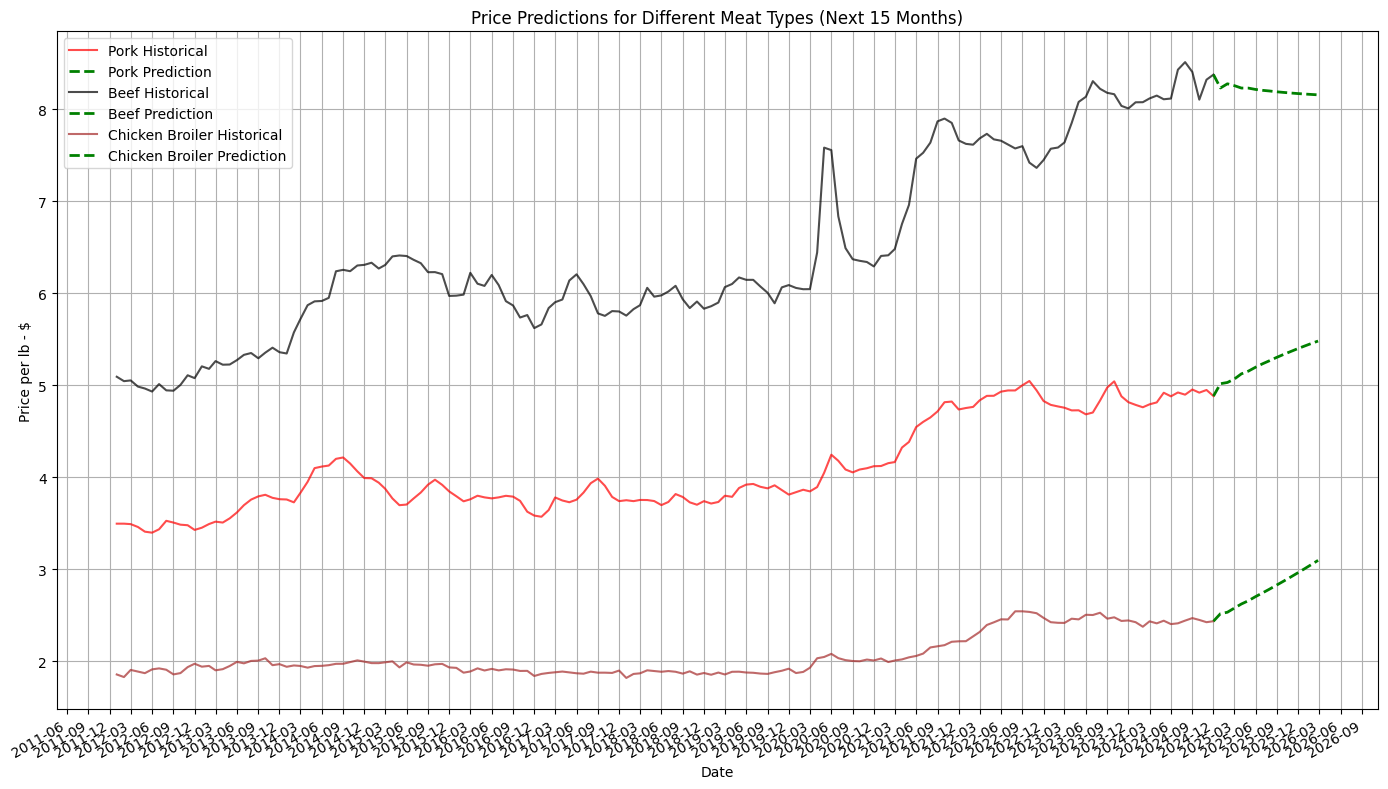

In [7]:
if 'Date' not in time_series.columns:
    start_date = datetime(2014, 1, 1)  
    dates = [start_date + timedelta(days=30*i) for i in range(len(time_series))]
    time_series['Date'] = dates

# Creating separate predictions for each meat type
meat_types = ['Pork', 'Beef', 'Chicken Broiler']
future_steps = 15
plt.figure(figsize=(14, 8))

# colors for actual value and predicted value
colors = {'Pork': ('red', 'green'), 
          'Beef': ('black', 'green'), 
          'Chicken Broiler': ('brown', 'green')}

# Dictionary to store predictions
prediction_values = {}
prediction_dates = {}

for meat_type in meat_types:
    # Filtering data for specific type
    meat_data = time_series[time_series['EFPG_name'].str.contains(meat_type, case=False, na=False)]
    
    # Drop missing values
    meat_data = meat_data.dropna(subset=['Price_per_lb'])
    
    # Extracting Price_per_lb as the target time series
    price_series = meat_data['Price_per_lb'].values
    
    #corresponding dates and convert to matplotlib date format
    date_series = pd.to_datetime(meat_data['Date']).values
    mpl_dates = mdates.date2num(date_series)  
    
    # Skip if there's no enough data
    if len(price_series) < 10:
        print(f"Not enough data for {meat_type}")
        continue
        
    # Scaling the data
    scaler = StandardScaler()
    price_series_scaled = scaler.fit_transform(price_series.reshape(-1, 1)).flatten()
    
    # Creating lagged features (using 3 time steps to predict the next)
    def create_lagged_features(data, lag=3):
        X, y = [], []
        for i in range(lag, len(data)):
            X.append(data[i-lag:i])
            y.append(data[i])
        return np.array(X), np.array(y)
    
    X, y = create_lagged_features(price_series_scaled)
    
    # Time-ordered split (not random)
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    # MLP model with regularization to prevent overfitting
    mlp = MLPRegressor(
        hidden_layer_sizes=(50, 25), 
        activation='relu',
        solver='adam', 
        alpha=0.001,  # L2 regularization
        max_iter=2000, 
        early_stopping=True,  # Stop when validation score doesn't improve
        validation_fraction=0.1,
        random_state=42
    )
    
    mlp.fit(X_train, y_train)
    
    # Test predictions
    y_pred = mlp.predict(X_test)
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    print(f"{meat_type} Mean Squared Error: {mse}")
    
    # Future predictions
    future_predictions = []
    current_window = price_series_scaled[-3:].copy()  # Using the last 3 time steps
    
    for _ in range(future_steps):
        next_pred = mlp.predict(current_window.reshape(1, -1))[0]
        future_predictions.append(next_pred)
        # Update the window by removing oldest value and adding the prediction
        current_window = np.append(current_window[1:], next_pred)
    
    # Inverse transform to get actual price values
    future_predictions_actual = scaler.inverse_transform(
        np.array(future_predictions).reshape(-1, 1)).flatten()
    
    # Generate future dates 
    last_date = pd.to_datetime(date_series[-1])
    future_dates_dt = [last_date + timedelta(days=30*(i+1)) for i in range(future_steps)]
    future_dates_mpl = mdates.date2num(future_dates_dt)  # Convert to matplotlib date format
    
    # Store predictions and dates for display
    prediction_values[meat_type] = future_predictions_actual
    prediction_dates[meat_type] = future_dates_dt
    
    # Get colors for this meat type (historical and prediction)
    hist_color, pred_color = colors.get(meat_type, ('blue', 'darkblue'))
    
    # Plot historical data with matplotlib date format
    plt.plot(mpl_dates, price_series, 
             color=hist_color, 
             alpha=0.7,
             label=f"{meat_type} Historical")
    
    # Plot future predictions with distinct prediction colors
    plt.plot(np.concatenate([[mpl_dates[-1]], future_dates_mpl]),
             [price_series[-1]] + list(future_predictions_actual),
             color=pred_color, 
             linestyle='--', 
             linewidth=2,
             label=f"{meat_type} Prediction")

# Formating the x-axis to show dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
plt.gcf().autofmt_xdate()  # Rotate date labels

plt.xlabel("Date")
plt.ylabel("Price per lb - $")
plt.title("Price Predictions for Different Meat Types (Next 15 Months)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Display the predicted values in a table format with dates
print("\nPredicted Values (Price per lb):")
print("-" * 100)
print(f"{'Date':^20}|{'Pork':^25}|{'Beef':^25}|{'Chicken Broiler':^25}")
print("-" * 100)
# Get the first meat type with predictions to use its dates
reference_meat = next((m for m in meat_types if m in prediction_dates), None)

if reference_meat:
    for i in range(future_steps):
        date_str = prediction_dates[reference_meat][i].strftime('%Y-%m-%d')
        step_values = []
        for meat_type in meat_types:
            if meat_type in prediction_values:
                val = prediction_values[meat_type][i]
                step_values.append(f"${val:.2f}")
            else:
                step_values.append("N/A")
        
        print(f"{date_str:^20}|{step_values[0]:^25}|{step_values[1]:^25}|{step_values[2]:^25}")


Predicted Values (Price per lb):
----------------------------------------------------------------------------------------------------
        Date        |          Pork           |          Beef           |     Chicken Broiler     
----------------------------------------------------------------------------------------------------
     2024-12-31     |          $5.02          |          $8.23          |          $2.52          
     2025-01-30     |          $5.03          |          $8.28          |          $2.53          
     2025-03-01     |          $5.07          |          $8.26          |          $2.58          
     2025-03-31     |          $5.12          |          $8.23          |          $2.62          
     2025-04-30     |          $5.15          |          $8.23          |          $2.66          
     2025-05-30     |          $5.20          |          $8.22          |          $2.70          
     2025-06-29     |          $5.23          |          $8.21         

In [9]:
#pip install feedparser


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import feedparser
import streamlit as st

def display_rss_feed(rss_url):
    feed = feedparser.parse(rss_url)
    st.header("📰 Latest News")
    for entry in feed.entries[:5]:  # Display only top 5
        st.markdown(f"**[{entry.title}]({entry.link})**")
        st.caption(entry.published)
        st.write(entry.summary)
        st.write("---")

# Example: Health or Tech RSS feed
rss_url = "http://feeds.bbci.co.uk/news/health/rss.xml"
display_rss_feed(rss_url)

2025-04-17 20:12:03.979 
  command:

    streamlit run C:\Users\sandeep\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
